In [1]:
import sys
sys.path.insert(0, '..')
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from mxnet.gluon import data as gdata
import sys
import time
from mxnet import gluon, init, autograd
from mxnet.gluon import loss as gloss, nn
import mxnet as mx
import numpy as np
import mxnet.ndarray as nd
from mxnet.gluon.data.vision import transforms

In [2]:
mnist_train = gdata.vision.MNIST(train=True)
mnist_test = gdata.vision.MNIST(train=False)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
feature, label = mnist_train[0]
feature.shape, feature.dtype

((28, 28, 1), numpy.uint8)

In [4]:
label, type(label), label.dtype
def get_mnist_labels(labels):
   text_labels = ['zero', 'one', 'two', 'three', 'four',
   'five', 'six', 'seven', 'eight', 'nine']
   return [text_labels[int(i)] for i in labels]

In [5]:
def show_mnist(images, labels):
   display.set_matplotlib_formats('svg')
   # Here _ means that we ignore (not use) variables
   _, figs = plt.subplots(1, len(images), figsize=(12, 12))
   for f, img, lbl in zip(figs, images, labels):
       f.imshow(img.reshape((28, 28)).asnumpy())
       f.set_title(lbl)
       f.axes.get_xaxis().set_visible(False)
       f.axes.get_yaxis().set_visible(False)

In [6]:
X, y = mnist_train[0:9]
# show_mnist(X, get_mnist_labels(y))

In [7]:
batch_size = 256
transformer = gdata.vision.transforms.ToTensor()
if sys.platform.startswith('win'):
   # 0 means no additional processes are needed to speed up the reading of
   # data
   num_workers = 0
else:
   num_workers = 4

train_iter = gdata.DataLoader(mnist_train.transform_first(transformer),
   batch_size, shuffle=True,
   num_workers=num_workers)
test_iter = gdata.DataLoader(mnist_test.transform_first(transformer),
   batch_size, shuffle=False,
   num_workers=num_workers)

In [8]:
start = time.time()
for X, y in train_iter:
   continue
'%.2f sec' % (time.time() - start)

#Initialize the Model
def init(net, optimizer='sgd', learning_rate=0.1, weight_decay=0.001, ctx=mx.cpu()):
   net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
   trainer = gluon.Trainer(net.collect_params(),
                           optimizer,
                           {'learning_rate': learning_rate, 'wd': weight_decay})
   return trainer

In [9]:
# Computing Accuracy
def accuracy(data_iterator, net,ctx=mx.cpu()):
   acc = mx.metric.Accuracy()
   for (data, label) in data_iterator:
       data = data.as_in_context(ctx)
       label = label.as_in_context(ctx)
       output = net(data)
       predictions = mx.nd.argmax(output, axis=1)
       acc.update(preds=predictions, labels=label)
   return acc.get()[1]

In [10]:
#Training the Model
def train(net, trainer, train_data, validation_data, epochs, ctx=mx.cpu()):
   training_accuracies = []
   validation_accuracies = []
   softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
   for e in range(epochs):
       tic = time.time()
       for (data, label) in train_data:
           data  = data.as_in_context(ctx)
           label = label.as_in_context(ctx)
           with autograd.record():
               output = net(data)
               loss = softmax_cross_entropy(output, label)
               loss.backward()
           trainer.step(data.shape[0])
       toc = time.time()
       train_accuracy = accuracy(train_data, net)
       training_accuracies.append(train_accuracy)
       validation_accuracy = accuracy(validation_data, net)
       validation_accuracies.append(validation_accuracy)
       print("Epoch#%d Time=%.2f Training=%.4f Validation=%.4f Diff=%.4f"
             % (e, toc-tic, train_accuracy, validation_accuracy, train_accuracy-validation_accuracy))
   return training_accuracies, validation_accuracies

In [11]:
#Plotting
def plot_accuracies(training_accuracies, validation_accuracies):
   epochs = len(training_accuracies)
   plt.clf()
   fig, ax = plt.subplots()
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   train_plot, = ax.plot(range(epochs), training_accuracies, label="Training accuracy")
   validation_plot, = ax.plot(range(epochs), validation_accuracies, label="Validation accuracy")
   plt.legend(handles=[train_plot,validation_plot])
   plt.xticks(np.arange(0, epochs, 5))
   ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
   plt.show()


Sequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(sigmoid))
  (1): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(None -> 16, kernel_size=(5, 5), stride=(1, 1), Activation(sigmoid))
  (3): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Dense(None -> 120, Activation(sigmoid))
  (5): Dense(None -> 84, Activation(sigmoid))
  (6): Dense(None -> 10, linear)
)
Epoch#0 Time=1.28 Training=0.0986 Validation=0.0958 Diff=0.0028
Epoch#1 Time=1.23 Training=0.1022 Validation=0.1010 Diff=0.0012
Epoch#2 Time=1.33 Training=0.1022 Validation=0.1010 Diff=0.0012
Epoch#3 Time=1.29 Training=0.0986 Validation=0.0958 Diff=0.0028
Epoch#4 Time=1.29 Training=0.1124 Validation=0.1135 Diff=-0.0011
Epoch#5 Time=1.33 Training=0.1022 Validation=0.1010 Diff=0.0012
Epoch#6 Time=1.27 Training=0.0987 Validation=0.0980 Diff=0.0007
Epoch#7 Time=1.30 Training=0.1124 Validation=0.1135 Diff=-0.0011
Epoch#8 Tim

<Figure size 432x288 with 0 Axes>

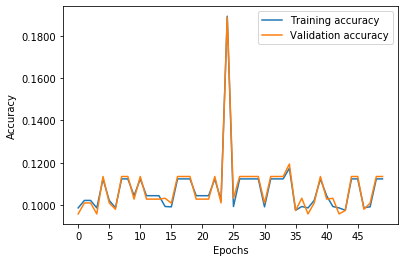

In [12]:
net = nn.Sequential()
# net.add(
#    nn.Conv2D(channels=64, kernel_size=3, strides=1, padding=1, activation='relu'),
#    nn.MaxPool2D(pool_size=2, strides=2, padding=0, ceil_mode=False),
#    nn.Conv2D(channels=64, kernel_size=3, strides=1, activation='relu'),
#    nn.MaxPool2D(pool_size=2, strides=2, padding=0, ceil_mode=False),
#    nn.Flatten(),
#    nn.Dense(256, activation='relu'),
#    nn.Dense(64, activation='relu'),
#    nn.Dense(10)
# )
net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.AvgPool2D(pool_size=2, strides=2),
    nn.Dense(120, activation='sigmoid'),
    nn.Dense(84, activation='sigmoid'),
    nn.Dense(10)
)
print(net)
trainer = init(net)
training_accuracies, validation_accuracies = train(net, trainer, train_iter, test_iter, 50)
plot_accuracies(training_accuracies, validation_accuracies)